# Test Delight on DESC-DC2 simulation  in the context of  Vera C. Rubin Obs (LSST) 


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 22 2022



- run at NERSC with **desc-python** python kernel.


Instruction to have a **desc-python** environnement:
- https://confluence.slac.stanford.edu/display/LSSTDESC/Getting+Started+with+Anaconda+Python+at+NERSC


This environnement is a clone from the **desc-python** environnement where package required in requirements can be addded according the instructions here
- https://github.com/LSSTDESC/desc-python/wiki/Add-Packages-to-the-desc-python-environment

We will use the parameter file "tmps/parametersTestRail.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys,os
sys.path.append('../')
from delight.io import *
from delight.utils import *
from photoz_gp import PhotozGP

# Initialisation

In [2]:
workdir = "tmp"

# Configuration parameters

- now parameters are generated in a dictionnary

In [3]:
list_of_files = os.listdir(workdir)
list_of_files.remove('data') 
list_of_files.remove('delight_data') 
if '.ipynb_checkpoints' in list_of_files:
    list_of_files.remove('.ipynb_checkpoints')
list_of_configfiles = sorted(list_of_files)

In [4]:
list_of_configfiles

['parametersTest-Sens.cfg',
 'parametersTest-VC1e4_ell1e6.cfg',
 'parametersTest.cfg',
 'parametersTest_1.cfg',
 'parametersTest_10.cfg',
 'parametersTest_11.cfg',
 'parametersTest_12.cfg',
 'parametersTest_13.cfg',
 'parametersTest_14.cfg',
 'parametersTest_15.cfg',
 'parametersTest_16.cfg',
 'parametersTest_17.cfg',
 'parametersTest_18.cfg',
 'parametersTest_19.cfg',
 'parametersTest_2.cfg',
 'parametersTest_20.cfg',
 'parametersTest_21.cfg',
 'parametersTest_3.cfg',
 'parametersTest_4.cfg',
 'parametersTest_5.cfg',
 'parametersTest_6.cfg',
 'parametersTest_7.cfg',
 'parametersTest_8.cfg',
 'parametersTest_9.cfg']

# Filters

- First, we must **fit the band filters with a gaussian mixture**. 
This is done with this script:

In [5]:
from delight.interfaces.rail.processFilters import processFilters

In [6]:
#configfilename = list_of_configfiles[9]
configfilename = 'parametersTest-Sens.cfg'
configfullfilename = os.path.join(workdir,configfilename) 
processFilters(configfullfilename)

2022-02-16 11:45:29,507 ipykernel_launcher.py delight.interfaces.rail.processFilters[5012] INFO ----- processFilters ------
2022-02-16 11:45:29,510 ipykernel_launcher.py delight.interfaces.rail.processFilters[5012] INFO parameter file is tmp/parametersTest-Sens.cfg


DC2LSST_u DC2LSST_g DC2LSST_r DC2LSST_i DC2LSST_z DC2LSST_y 

# SED

- Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [7]:
from delight.interfaces.rail.processSEDs import processSEDs

In [8]:
#configfilename = list_of_configfiles[9]
configfilename = 'parametersTest-Sens.cfg'
configfullfilename = os.path.join(workdir,configfilename) 
processSEDs(configfullfilename)

2022-02-16 11:46:23,264 ipykernel_launcher.py, delight.interfaces.rail.processSEDs[5012] INFO --- Process SED ---


# Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to 1e4 objects it should only take a few minutes max, depending on the settings above.

## Template Fitting

In [9]:
from delight.interfaces.rail.templateFitting import templateFitting

In [10]:
templateFitting(configfullfilename)

2022-02-16 11:46:46,372 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[5012] INFO --- TEMPLATE FITTING ---
2022-02-16 11:46:46,379 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[5012] INFO ==> New Prior calculation from Benitez
2022-02-16 11:46:46,390 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[5012] INFO Thread number / number of threads: 1 , 1
2022-02-16 11:46:46,396 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[5012] INFO Input parameter file:tmp/parametersTest-Sens.cfg
2022-02-16 11:46:46,461 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[5012] INFO Number of Target Objects 420
2022-02-16 11:46:46,463 ipykernel_launcher.py, delight.interfaces.rail.templateFitting[5012] INFO Thread 0 , analyzes lines 0 , to 420


## Gaussian Process

### Attempt at cross-examination of V_C and ellSigmaPrior influence

2022-02-16 11:47:01,386 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO --- DELIGHT-LEARN ---
2022-02-16 11:47:01,458 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO Number of Training Objects 3755
2022-02-16 11:47:01,460 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO Thread 0 , analyzes lines 0 , to 3755


Creation of GP with V_C = 0.01, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.


2022-02-16 11:48:40,729 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO --- DELIGHT-APPLY ---
2022-02-16 11:48:40,844 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Number of Training Objects 3755
2022-02-16 11:48:40,846 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Number of Target Objects 420
2022-02-16 11:48:40,849 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Thread 0 , analyzes lines 0 to 420


Creation of GP with V_C = 0.01, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.
Study of the influence of ellPriorSigma on likelihood and evidences
Computation of likelihood and evidences for ellPriorSigma = 0.5
0 0.5256772041320801 0.040793657302856445 0.027221202850341797
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
100 0.43707823753356934 0.025931358337402344 0.05261397361755371
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
200 0.43671226501464844 0.02471780776977539 0.05790591239929199
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
300 0.4575939178466797 0.02890491485595703 0.042249441146850586
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
400 0.739593505859375 0.031215906143188477 0.04900336265563965
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)


2022-02-16 11:58:10,186 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO --- DELIGHT-LEARN ---
2022-02-16 11:58:10,253 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO Number of Training Objects 3755
2022-02-16 11:58:10,257 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO Thread 0 , analyzes lines 0 , to 3755


Creation of GP with V_C = 1.0, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.


2022-02-16 11:59:44,717 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO --- DELIGHT-APPLY ---
2022-02-16 11:59:44,811 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Number of Training Objects 3755
2022-02-16 11:59:44,813 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Number of Target Objects 420
2022-02-16 11:59:44,817 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Thread 0 , analyzes lines 0 to 420


Creation of GP with V_C = 1.0, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.
Study of the influence of ellPriorSigma on likelihood and evidences


/home/photoz/Intern2022_PhotoZ/Delight/desc-dc2/delightApply_paramSpecPlot.py:198: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3, axs3 = plt.subplots(1, 2, figsize=(12,10), constrained_layout=True)


Computation of likelihood and evidences for ellPriorSigma = 0.5
0 0.5289585590362549 0.022027969360351562 0.02698040008544922
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
100 0.43142247200012207 0.021600961685180664 0.04682779312133789
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
200 0.4447903633117676 0.02511453628540039 0.062273263931274414
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
300 0.43015193939208984 0.02825188636779785 0.04534792900085449
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
400 0.43495798110961914 0.030317306518554688 0.0273134708404541
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)


2022-02-16 12:08:53,658 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO --- DELIGHT-LEARN ---
2022-02-16 12:08:53,719 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO Number of Training Objects 3755
2022-02-16 12:08:53,722 ipykernel_launcher.py, delightLearn_paramSpec[5012] INFO Thread 0 , analyzes lines 0 , to 3755


Creation of GP with V_C = 10000.0, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.


2022-02-16 12:10:24,460 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO --- DELIGHT-APPLY ---
2022-02-16 12:10:24,580 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Number of Training Objects 3755
2022-02-16 12:10:24,583 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Number of Target Objects 420
2022-02-16 12:10:24,585 ipykernel_launcher.py, delightApply_paramSpecPlot[5012] INFO Thread 0 , analyzes lines 0 to 420


Creation of GP with V_C = 10000.0, V_L = 0.1, alpha_C = 1000.0, alpha_L = 100.0.
Study of the influence of ellPriorSigma on likelihood and evidences
Computation of likelihood and evidences for ellPriorSigma = 0.5
0 0.5754640102386475 0.023509502410888672 0.027730226516723633
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
100 0.51220703125 0.022257328033447266 0.040380239486694336
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
200 0.46108484268188477 0.022379636764526367 0.02320241928100586
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
300 0.4454629421234131 0.02315688133239746 0.030349016189575195
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)
400 0.8531982898712158 0.08663558959960938 0.04993557929992676
Likelihoods shape : (300, 3755)
Evidences shape : (3755,)
PDFs shape : (420, 300)


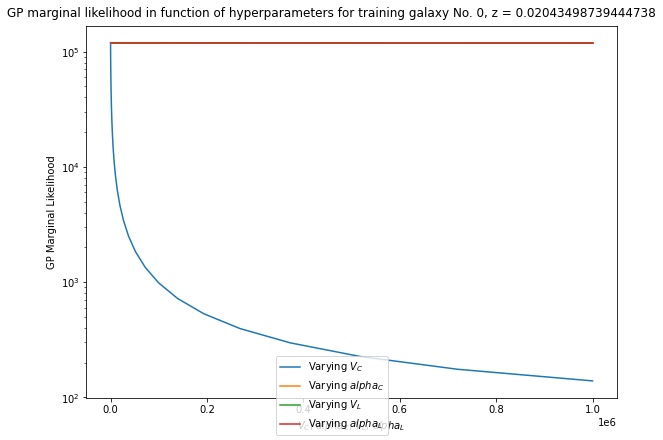

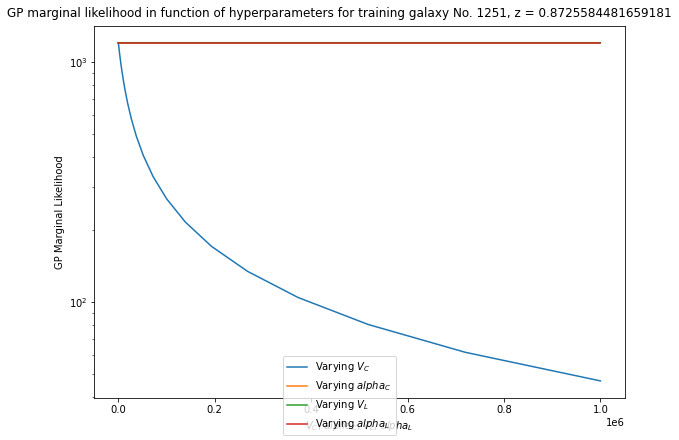

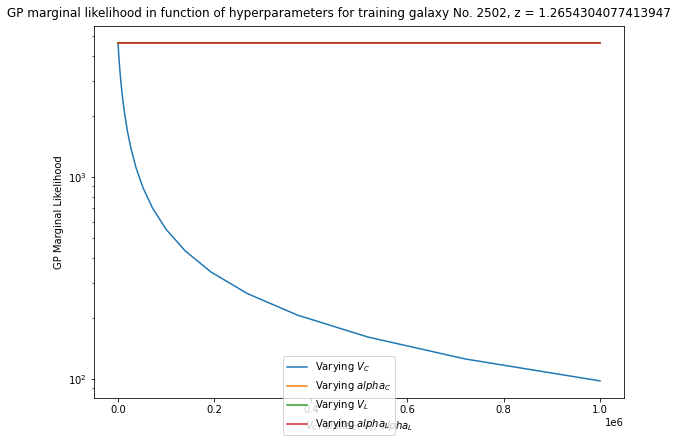

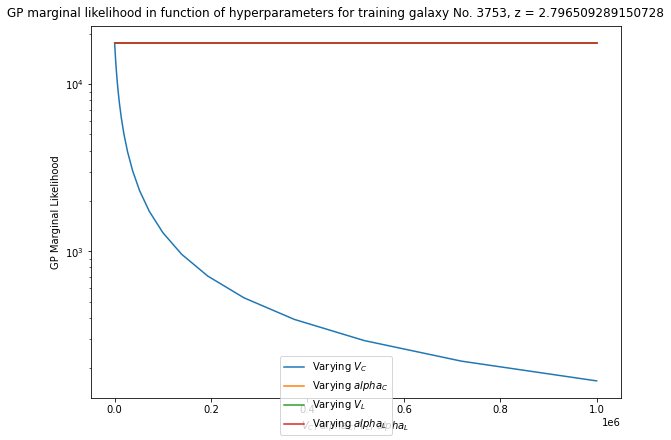

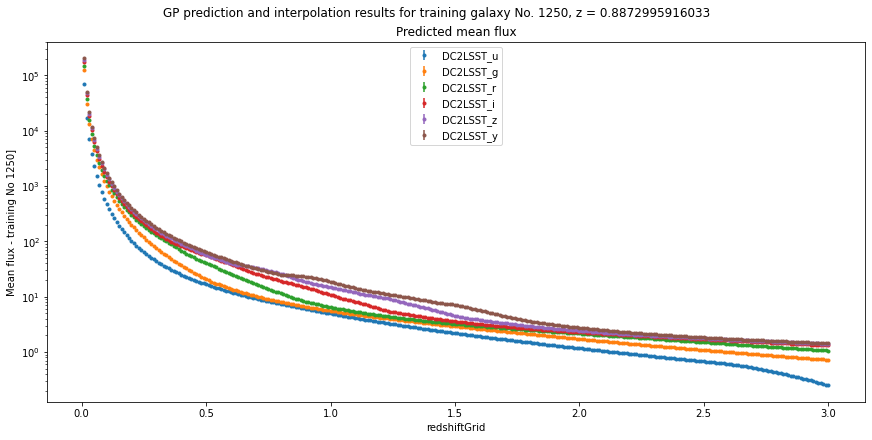

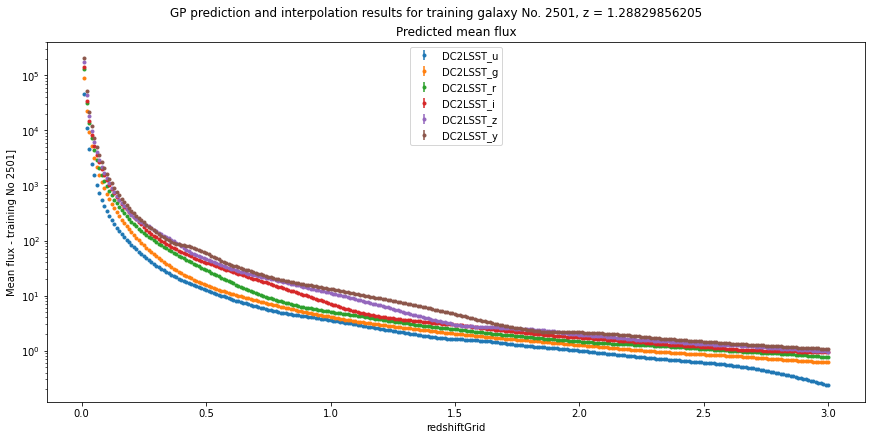

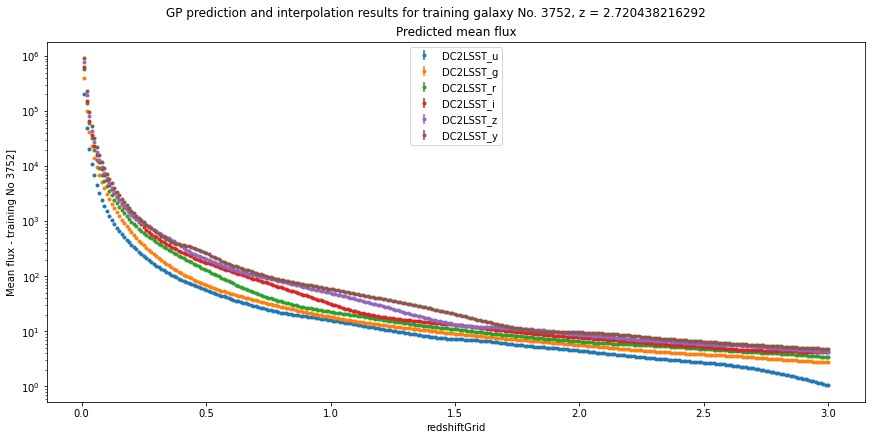

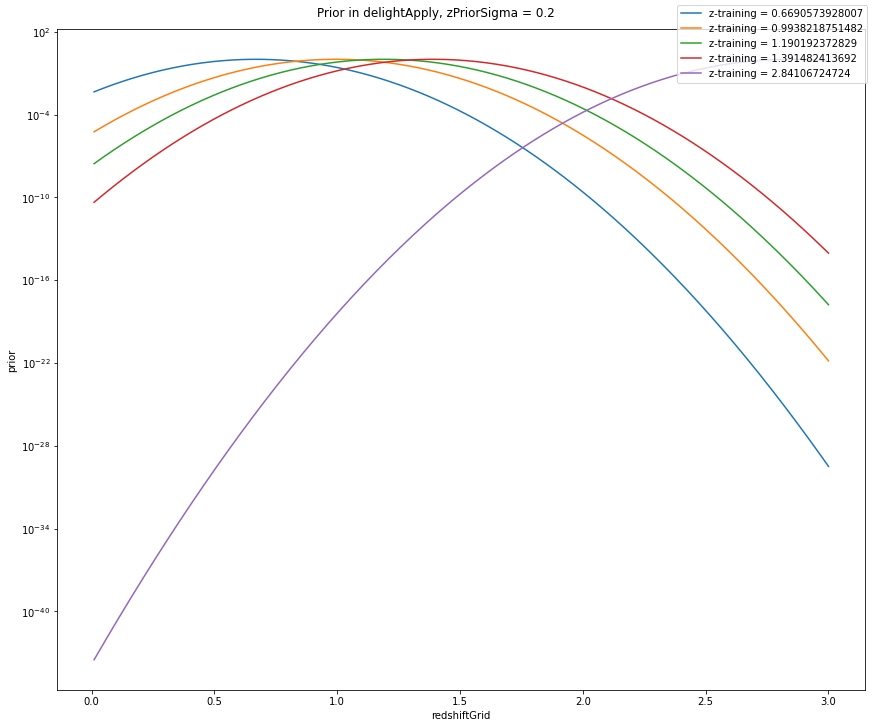

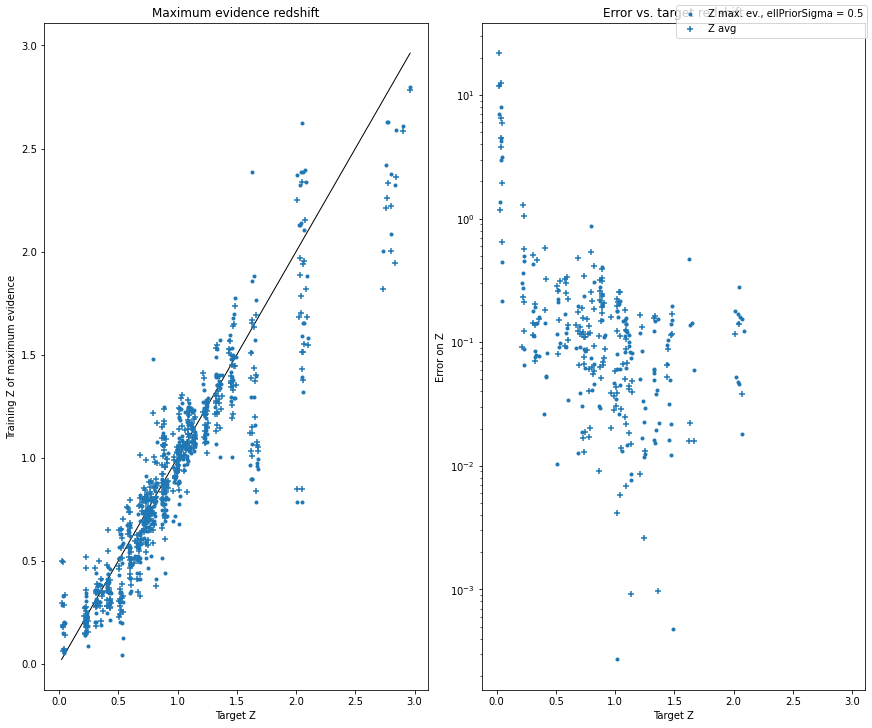

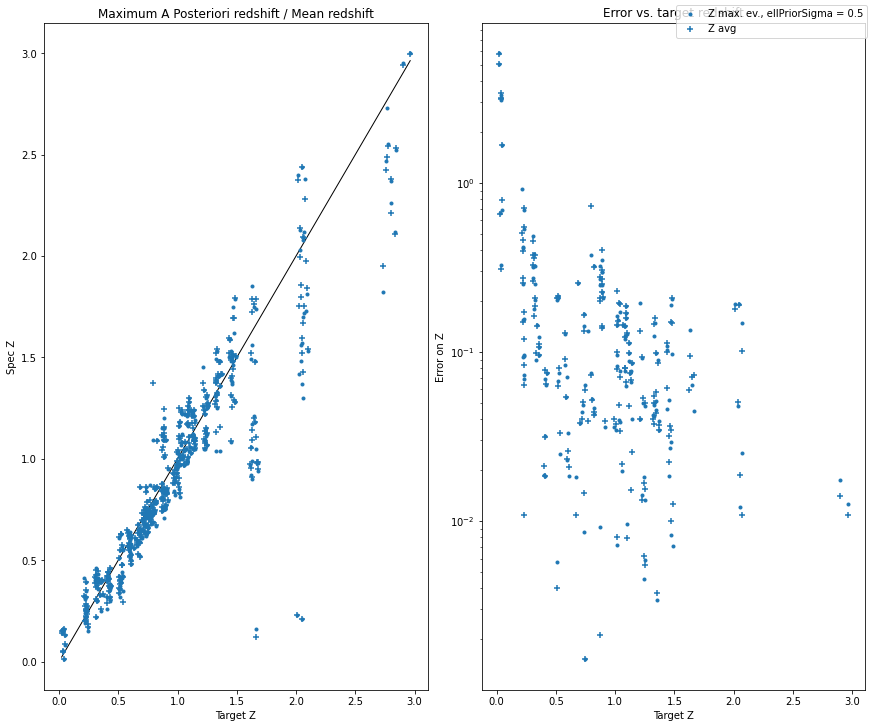

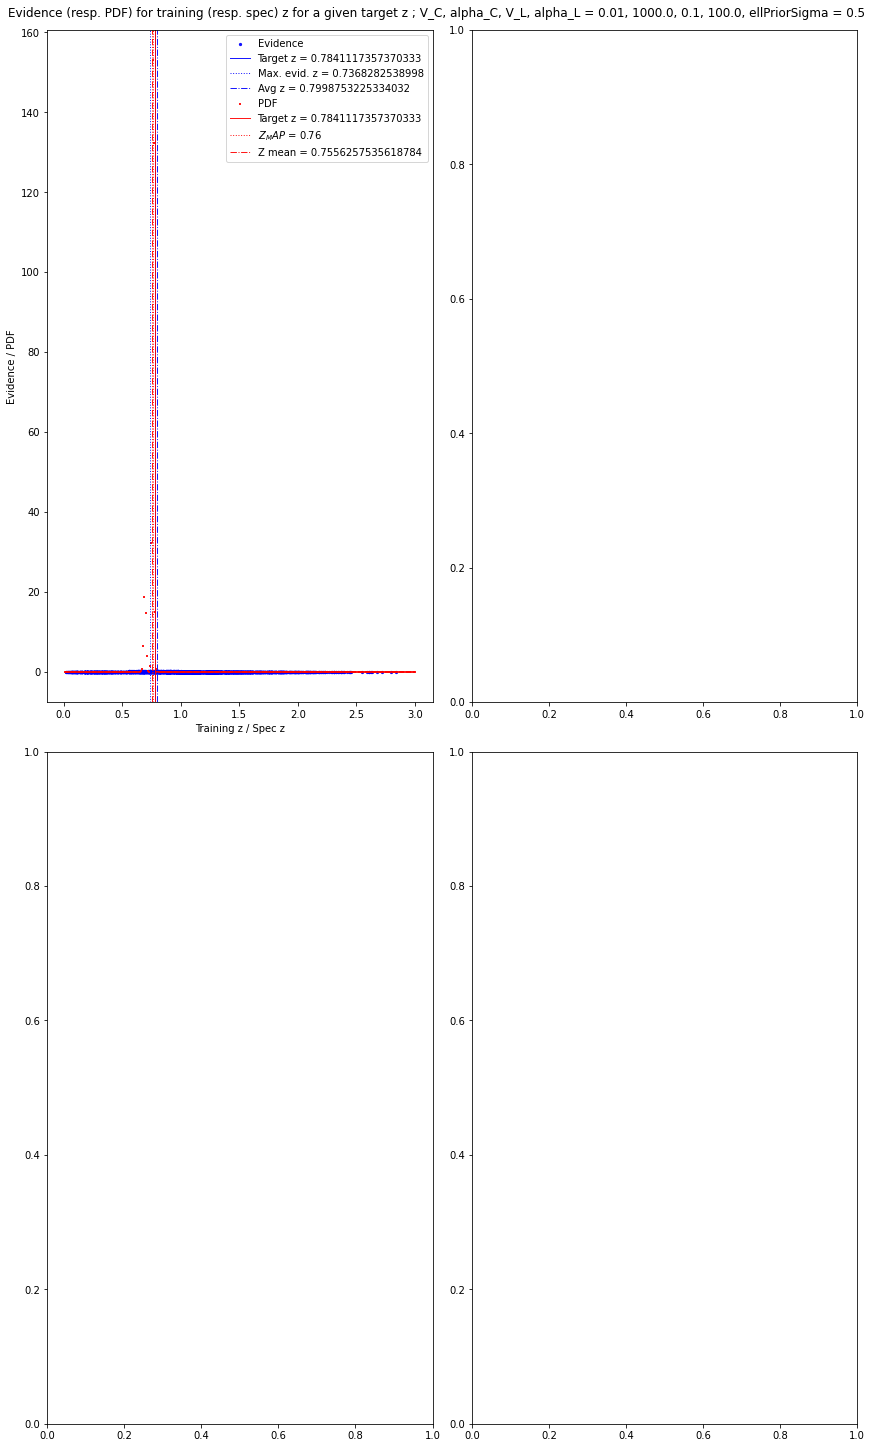

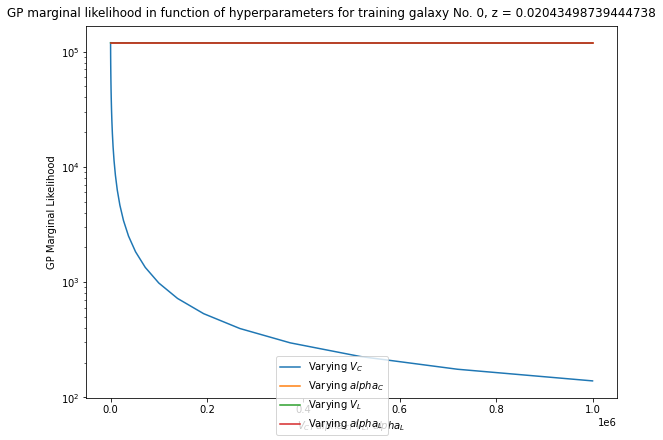

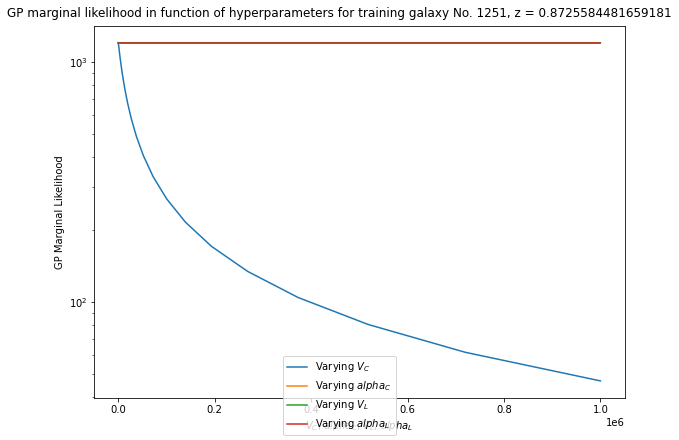

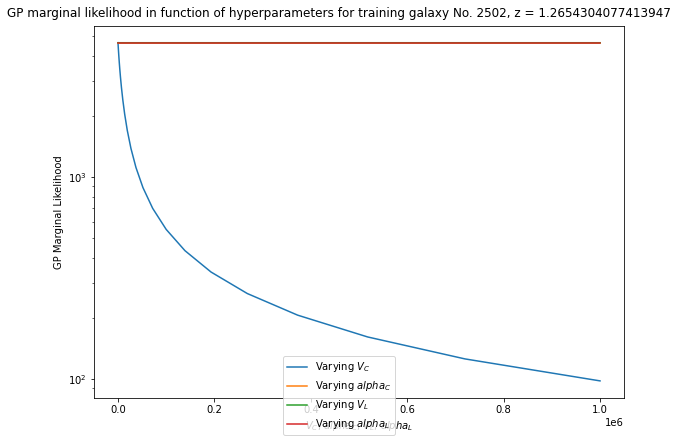

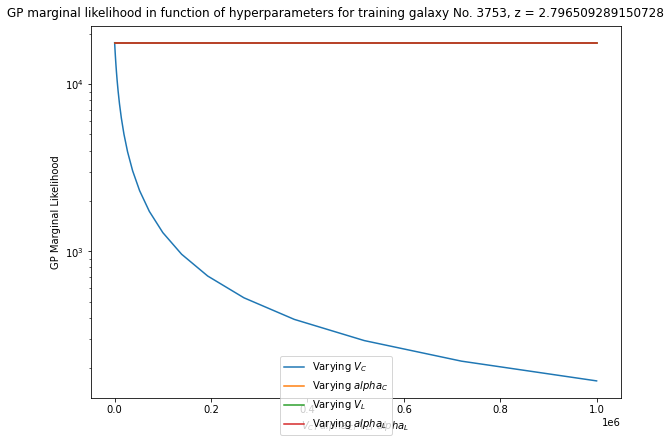

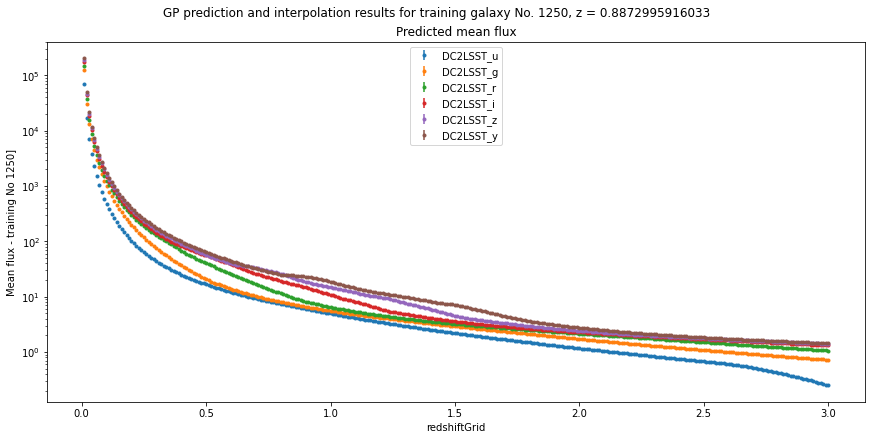

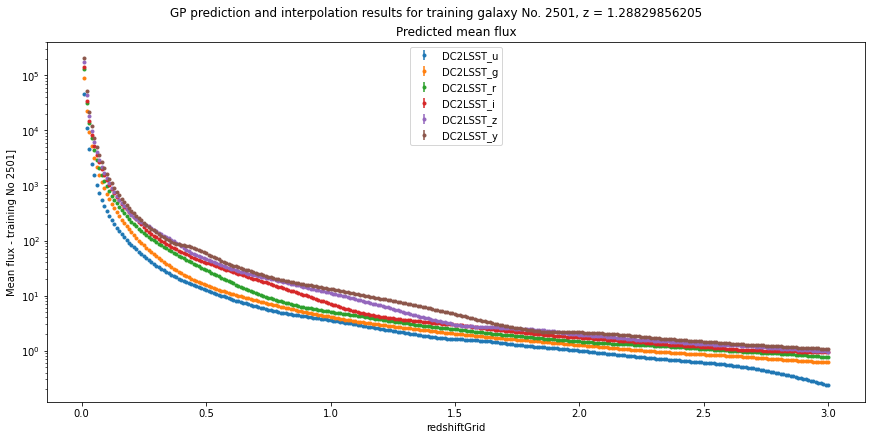

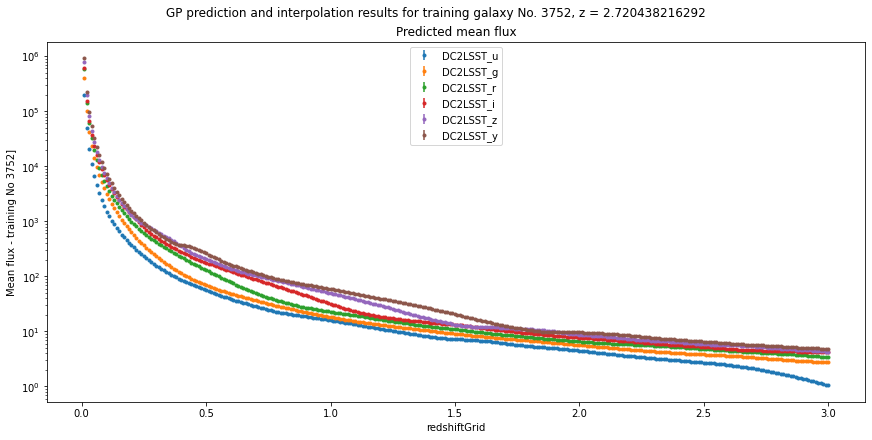

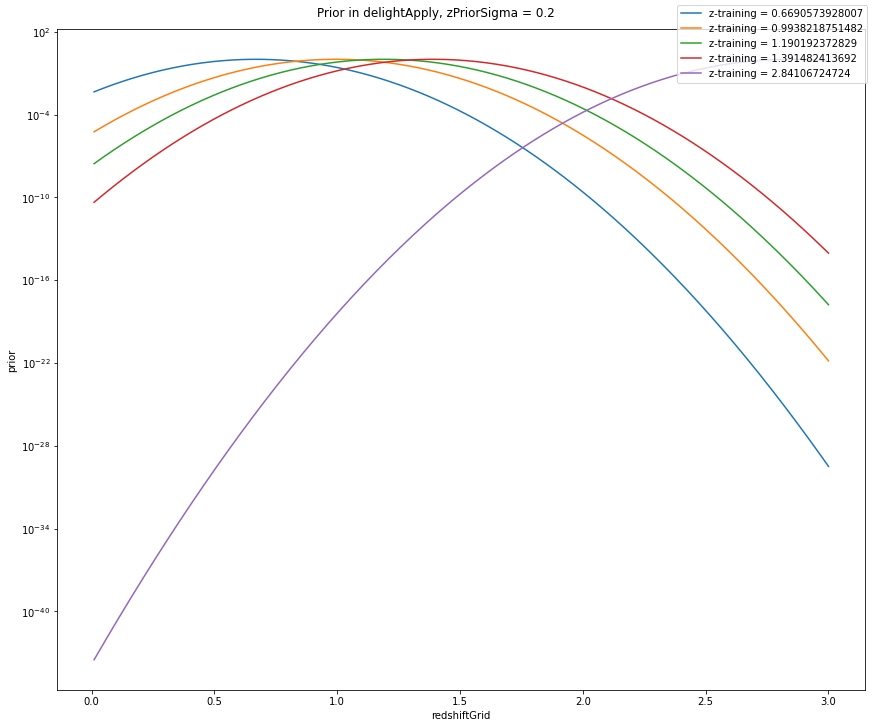

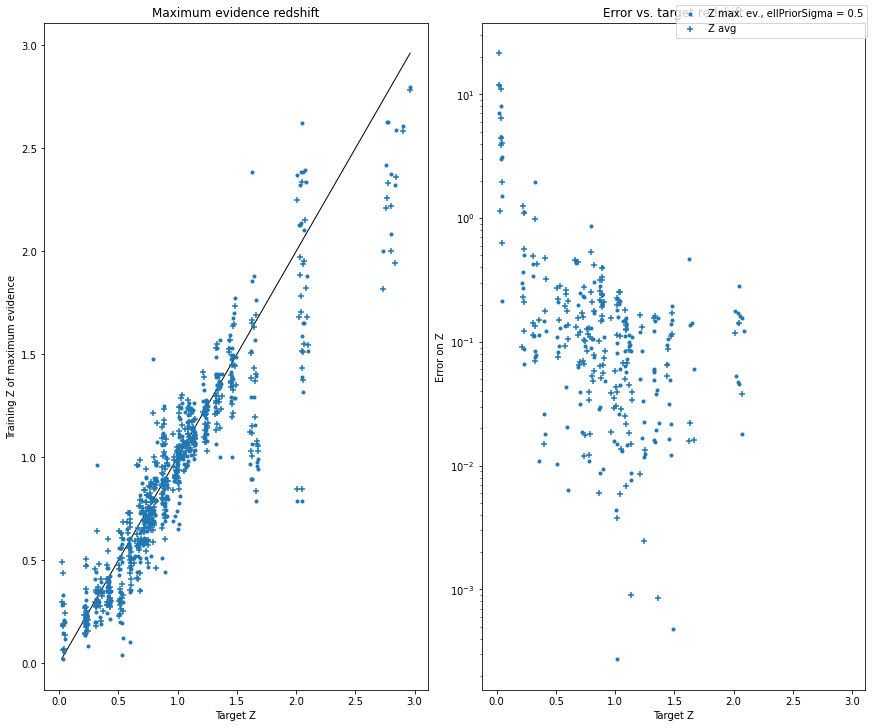

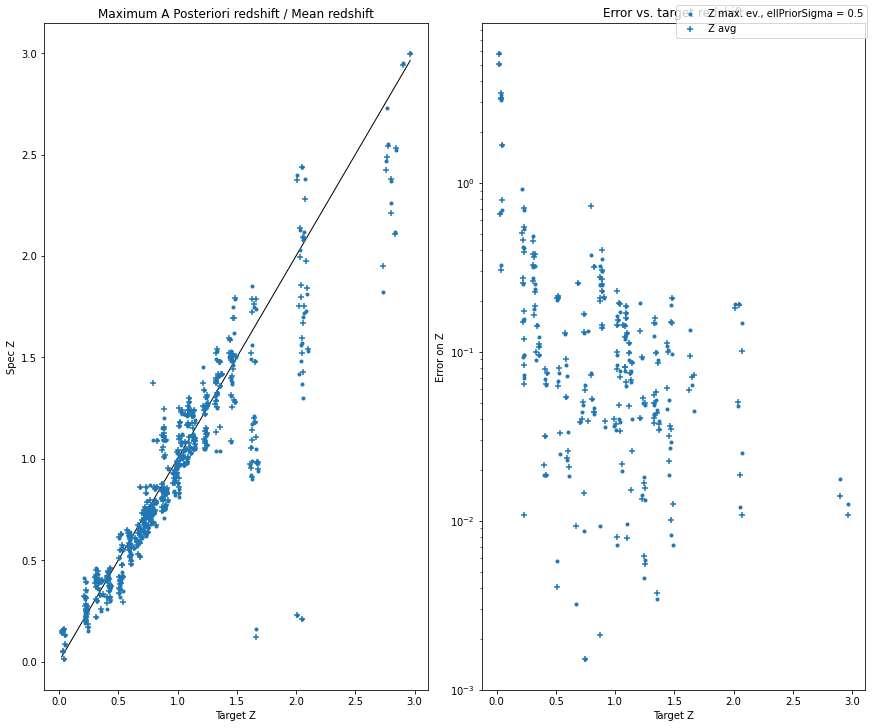

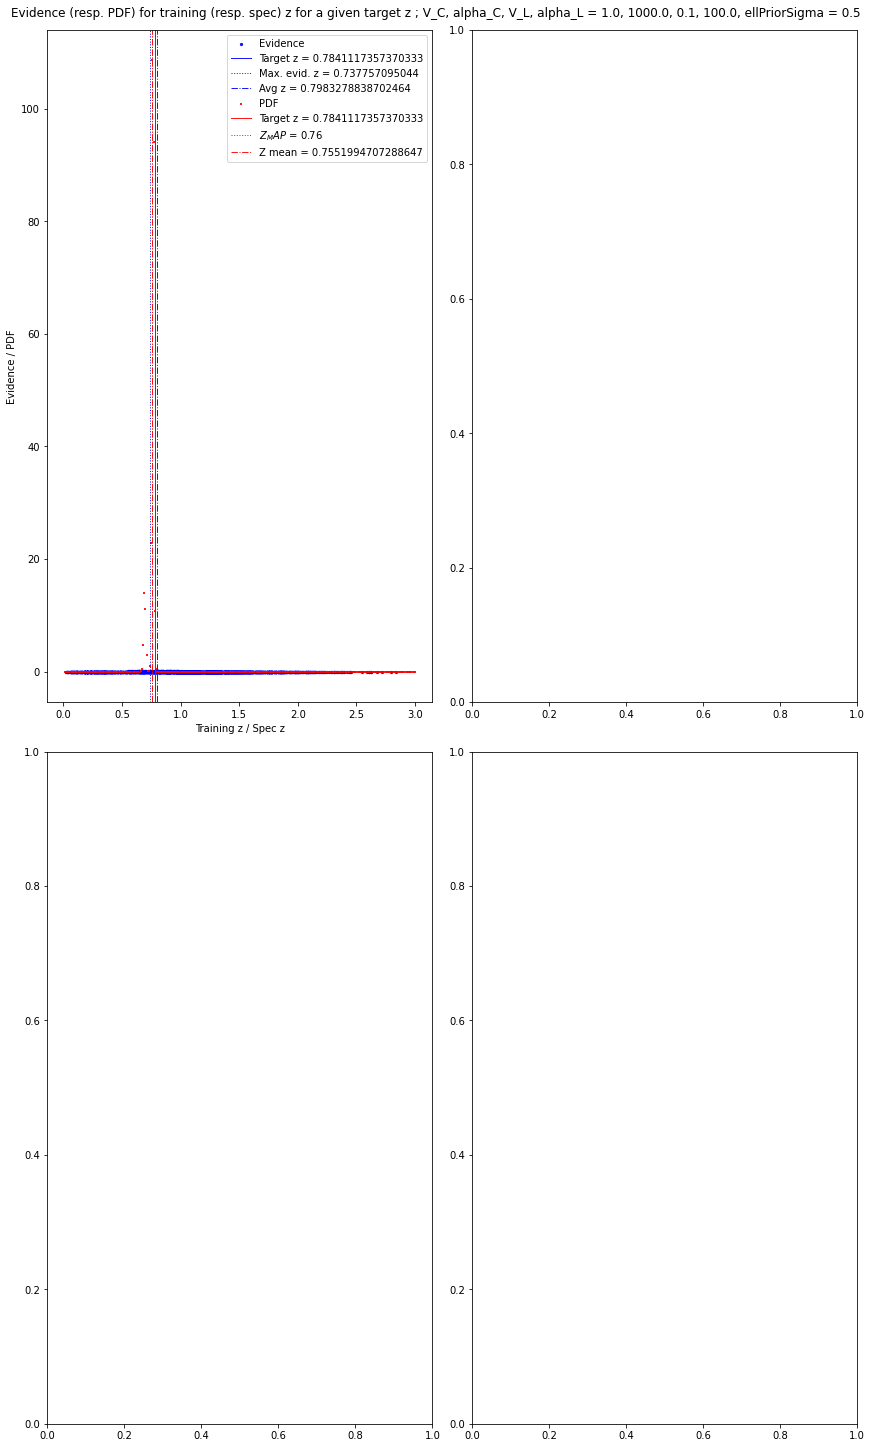

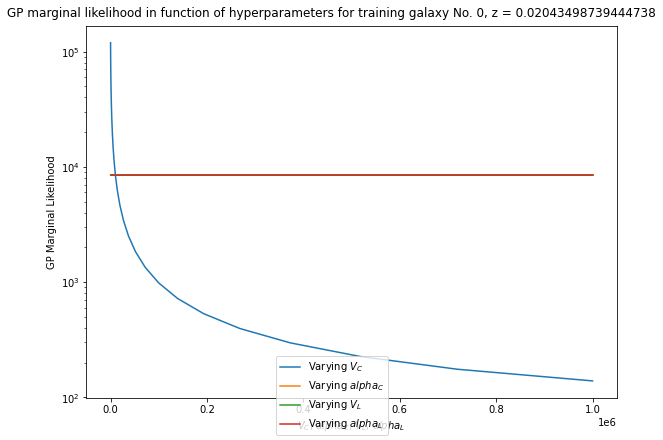

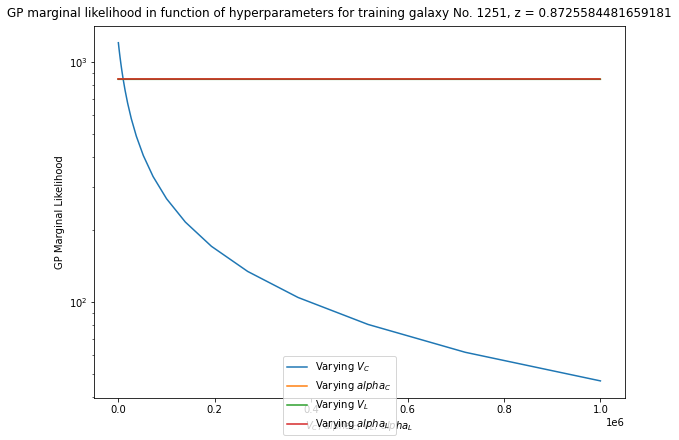

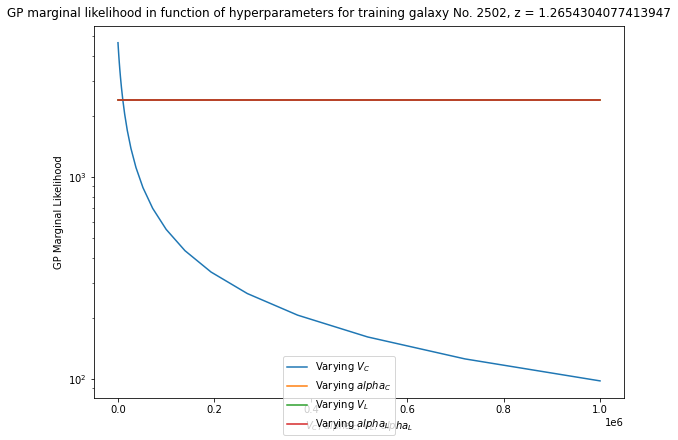

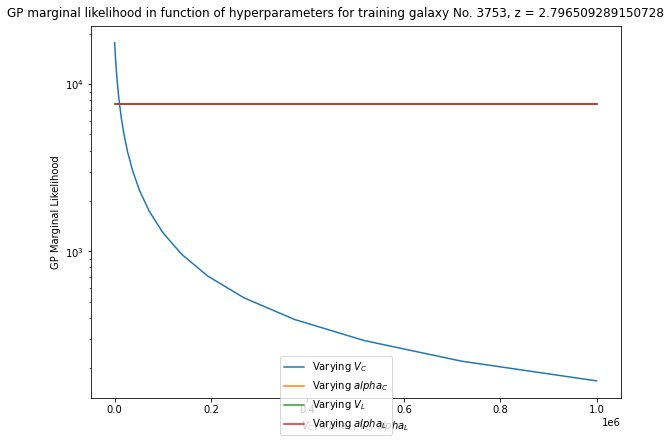

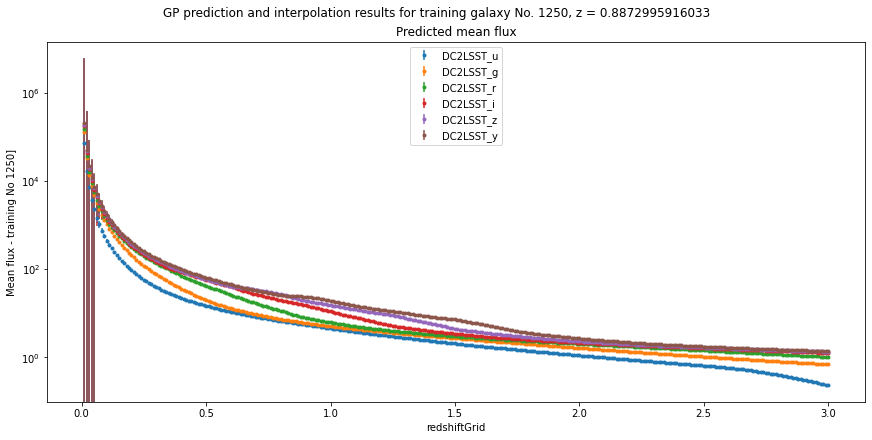

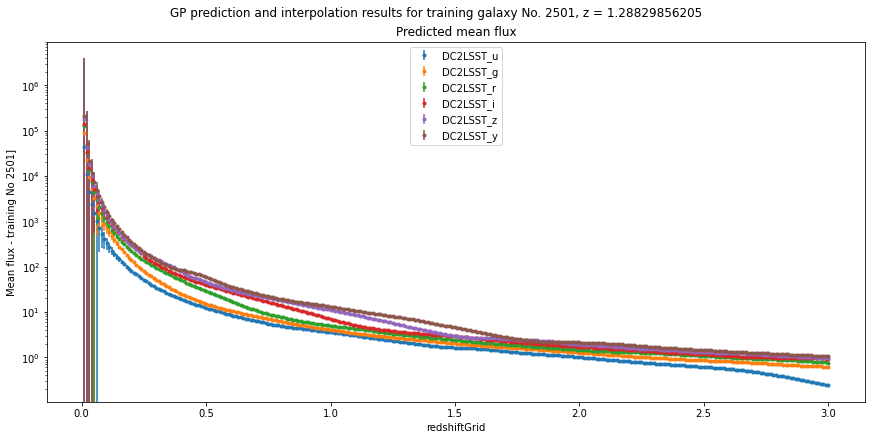

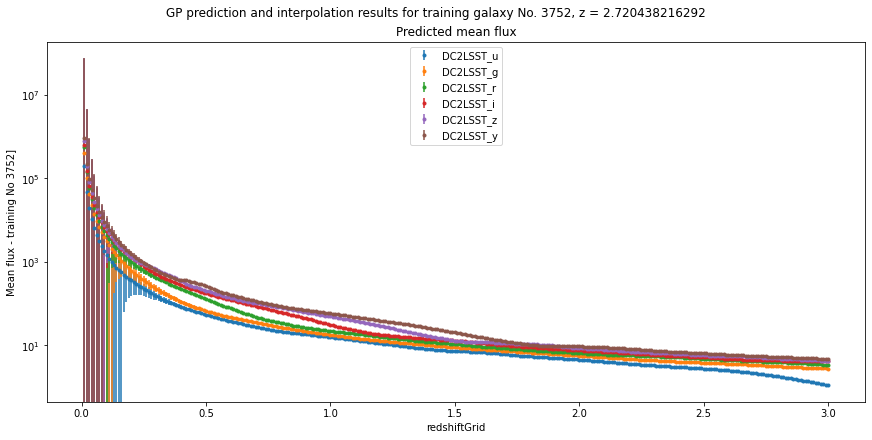

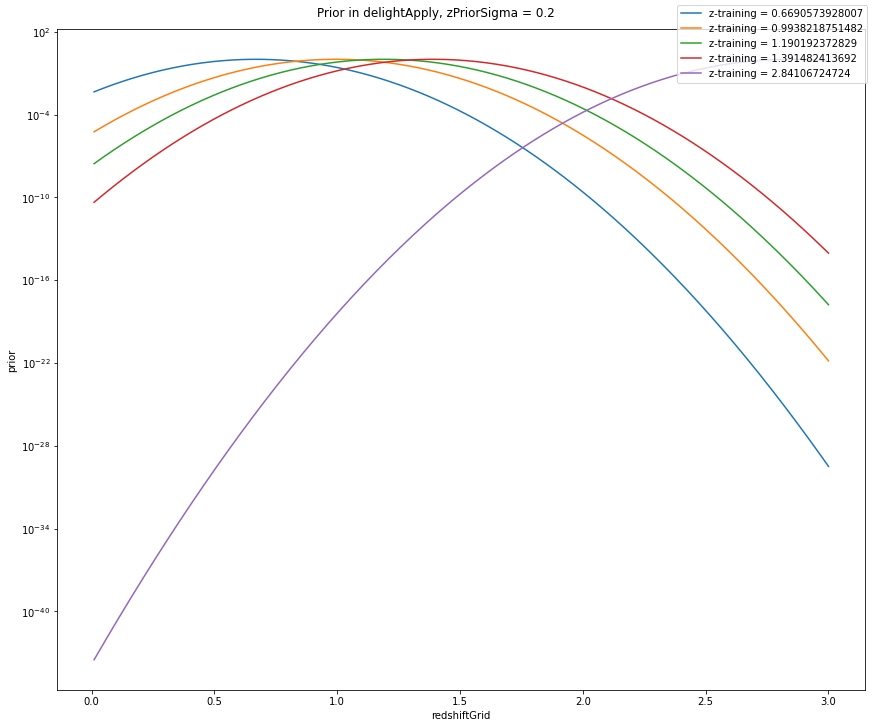

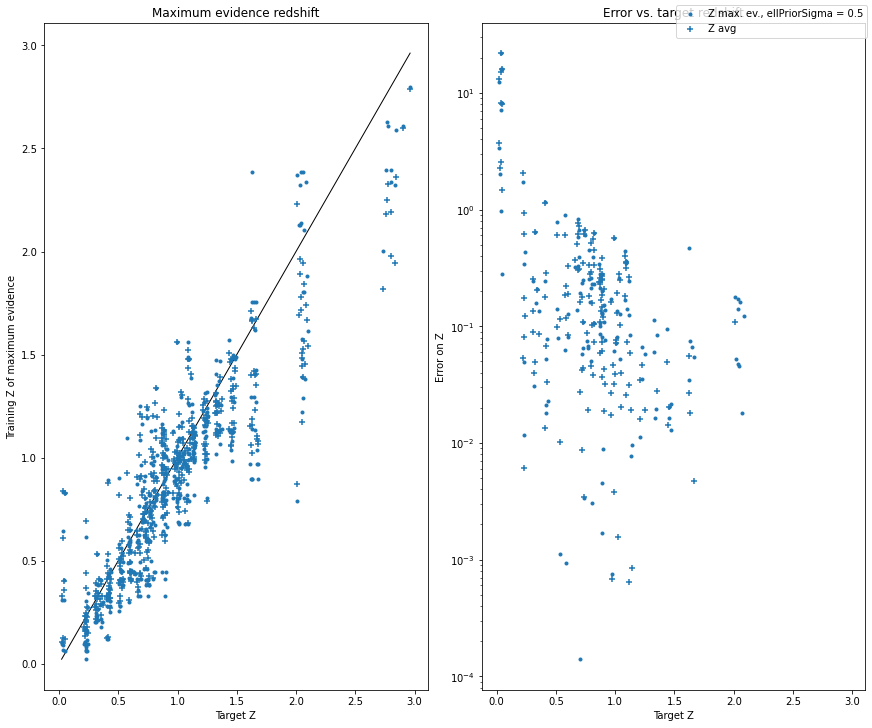

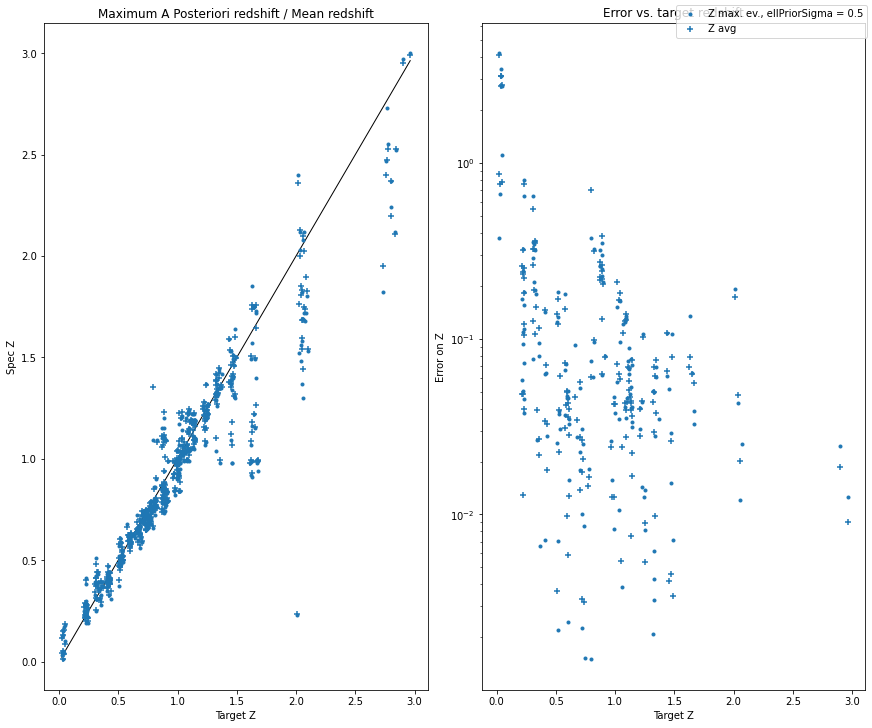

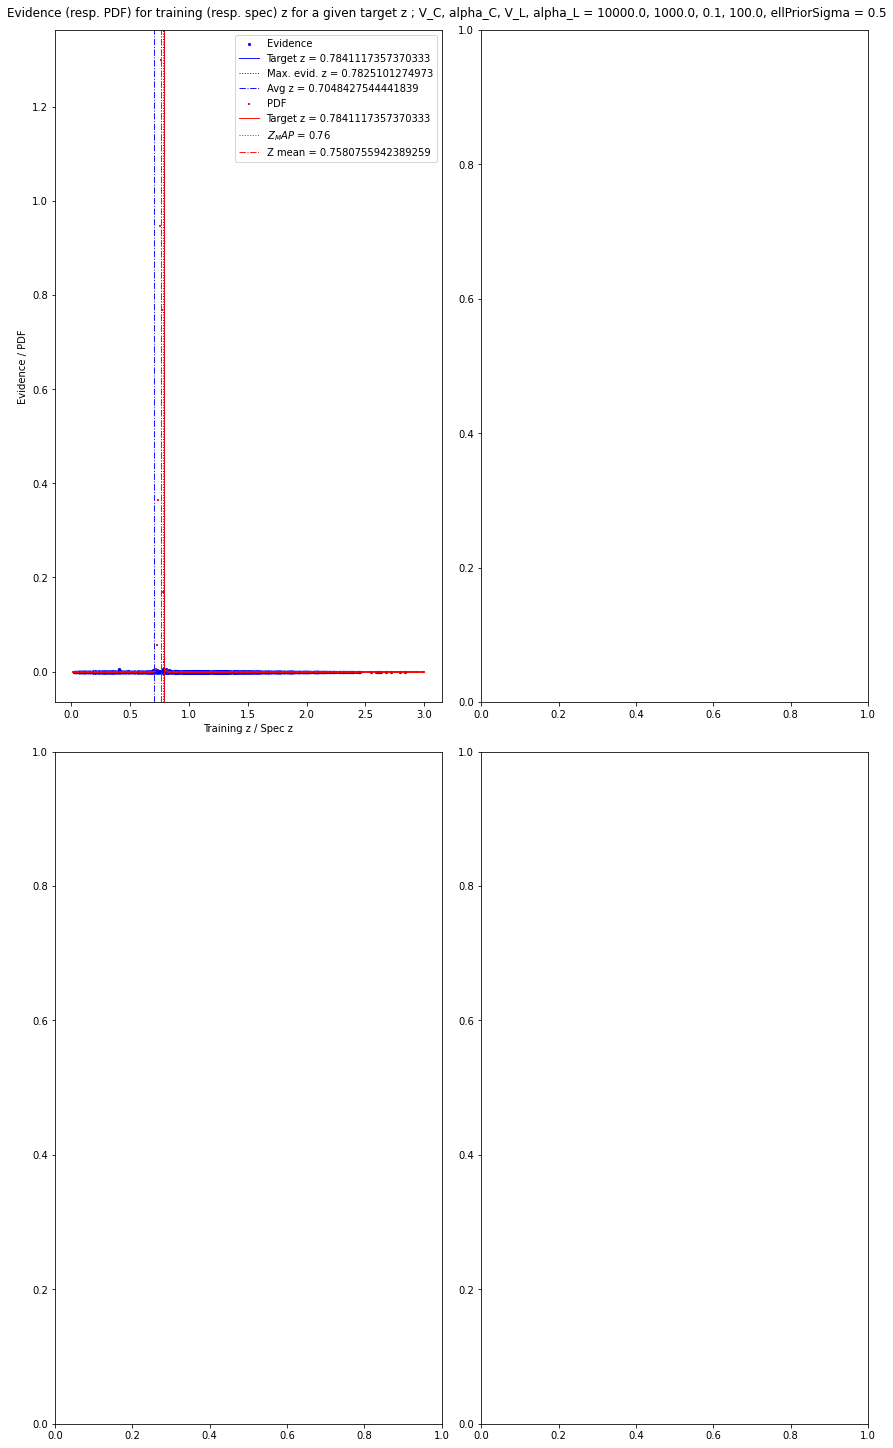

In [11]:
from delightLearn_paramSpec import delightLearn_paramSpec
from delightApply_paramSpecPlot import delightApply_paramSpecPlot
for paramVal in [0.01, 1.0, 1e4]:
    delightLearn_paramSpec(configfullfilename, V_C=paramVal)
    delightApply_paramSpecPlot(configfullfilename, V_C=paramVal, sensitivity=True, ellPriorSigma_list=[0.5])

# Analyze the outputs

In [12]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile(configfullfilename, verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [13]:
# Load the PDF files
metrics = np.loadtxt(params['metricsFile'])
metricscww = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

235 4.455370787940302
332 73.11374587327808
360 76.44411073380023
413 3.9332236787741324
7 90.2025621204147
376 65.76070077491129
314 56.272397722235425
83 30.48290585591118
213 72.05639351724247
365 63.851293157791154
112 9.383323373629745
207 61.82028735336979
202 58.957218912331854
233 2.7754772152015392
100 52.20391781920003
379 69.52839874028241
349 37.02061499036003
242 8.341222691882864
115 31.46464399234787
222 8.119058042661493


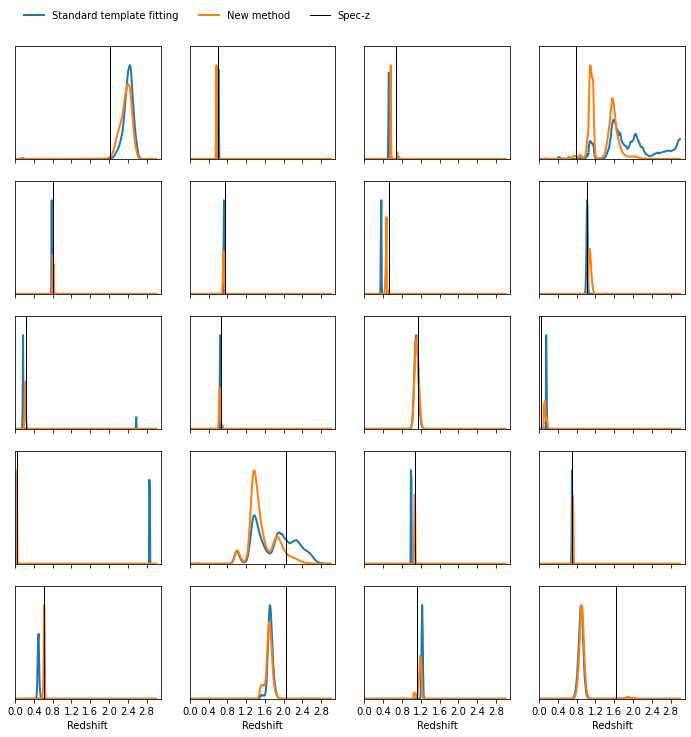

In [14]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(12, 12), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label='Spec-z')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    print(ymax)
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8 ])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


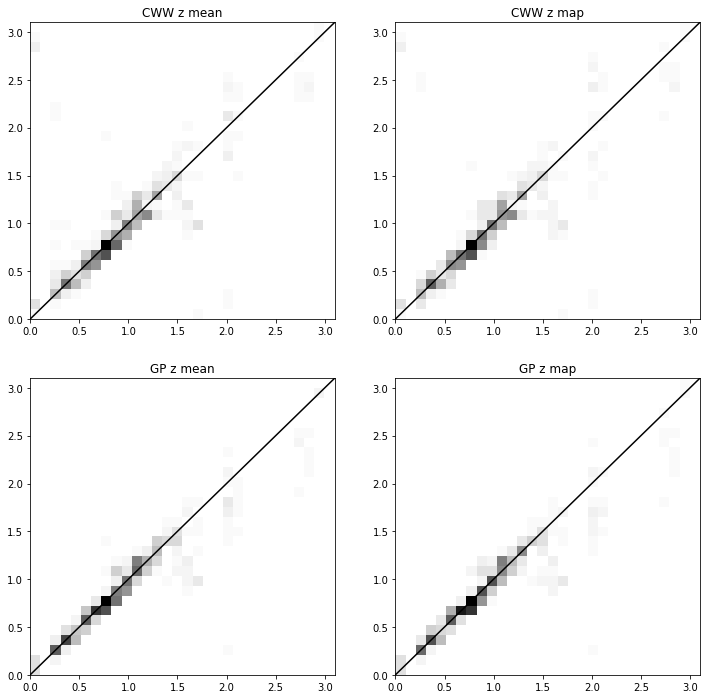

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
zmax = 3.1
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
#fig.tight_layout()

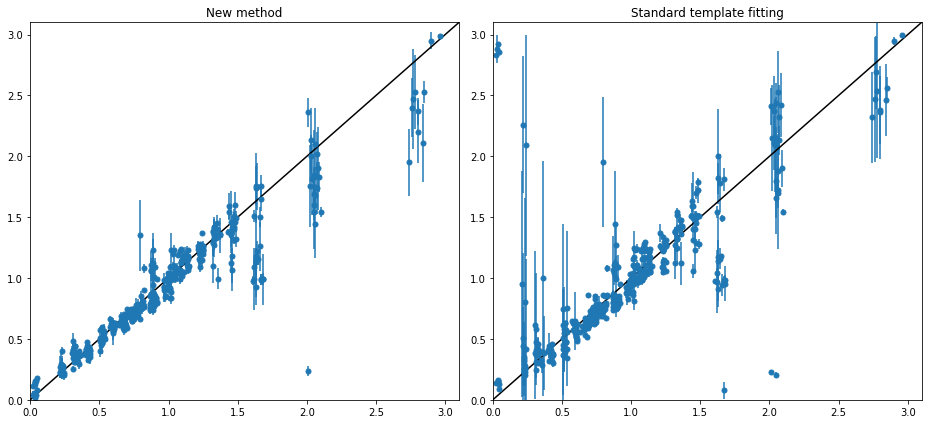

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

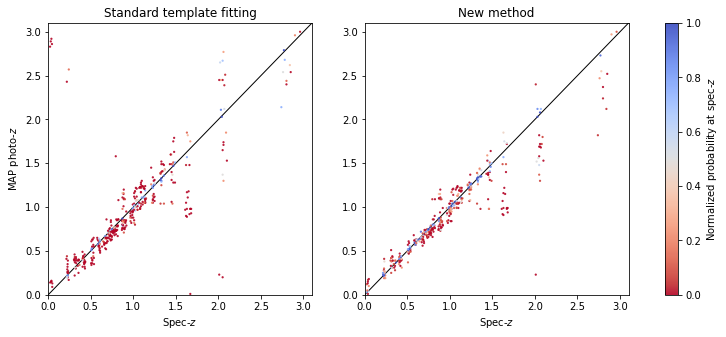

In [17]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.